This notebook creates plots to show how well calibrated the output of our models are. For a perfectly calibrated model, the output corresponds to probabilities, i.e., a record that scores 0.1 would have a 10% probability of being a critical error. 

In [37]:
import os
import pandas as pd
from mtqe.data.loaders import load_ced_test_data, load_ced_data
from mtqe.utils.paths import EVAL_DIR, PREDICTIONS_DIR
from mtqe.utils.plots import create_histogram_plot, create_calib_plot
from mtqe.utils.language_pairs import LI_LANGUAGE_PAIRS_WMT_21_CED
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve

In [38]:
# Set parameters for rest of analysis
EXPERIMENT_GROUP_NAME = 'train_multilingual_auth_data_all'
THRESHOLD_STRATEGY = 'default'
FILE_SUFFIX = 'median_results.csv'
CHART_NAME = 'Multilingual Authentic Data - one-step'

In [39]:
# Get the location of the evaluation data for the experiment group of interest - combine the en-ja directory if it is in a 
# separate folder
eval_files = [os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME, file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME)) if file.endswith(FILE_SUFFIX)]
enja_separate = False
if os.path.isdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')):
    eval_files.extend([os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja', file) for file in os.listdir(os.path.join(EVAL_DIR, EXPERIMENT_GROUP_NAME + '_enja')) if file.endswith(FILE_SUFFIX)])
    enja_separate = True
    

In [40]:
# Concatenate the evaluation data
dfs = []
for file in eval_files:
    df = pd.read_csv(file)
    dfs.append(df)

df_eval_results = pd.concat(dfs)

In [41]:
# Filter on the threshold strategy
df_eval_results = df_eval_results[(df_eval_results['threshold_strategy'] == THRESHOLD_STRATEGY)]
df_eval_dev_results = df_eval_results[(df_eval_results['split']=='dev')]
df_eval_test_results = df_eval_results[(df_eval_results['split']=='test')]

In [42]:
# Get lists of dev data to create plot
preds = []
targets = []
indices = []
titles = []
for lp in LI_LANGUAGE_PAIRS_WMT_21_CED:
    seed = df_eval_dev_results[df_eval_dev_results['language_pair']==lp].iloc[0]['seed']
    mcc = df_eval_dev_results[df_eval_dev_results['language_pair']==lp].iloc[0]['MCC']
    precision = df_eval_dev_results[df_eval_dev_results['language_pair']==lp].iloc[0]['precision']
    recall = df_eval_dev_results[df_eval_dev_results['language_pair']==lp].iloc[0]['recall']
    titles.append('Language pair:' + lp)
    threshold = df_eval_dev_results[df_eval_dev_results['language_pair']==lp].iloc[0]['threshold']
    file_prefix = lp + '_dev_' + str(seed)
    if lp == 'en-ja' and enja_separate:
        folder = EXPERIMENT_GROUP_NAME + '_enja'
    else:
        folder = EXPERIMENT_GROUP_NAME
    for file in os.listdir(os.path.join(PREDICTIONS_DIR, 'ced_data', folder)):
        if file.startswith(file_prefix) and file.endswith('.csv'):
            # found predictions
            df_preds = pd.read_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', folder, file))
            scores = df_preds['score'].to_numpy()
            scores = 1 - scores
            preds.append(scores)
    targets.append(1 - load_ced_data('dev', lp)['score'].to_numpy())
    indices.append(load_ced_data('dev', lp)['idx'])

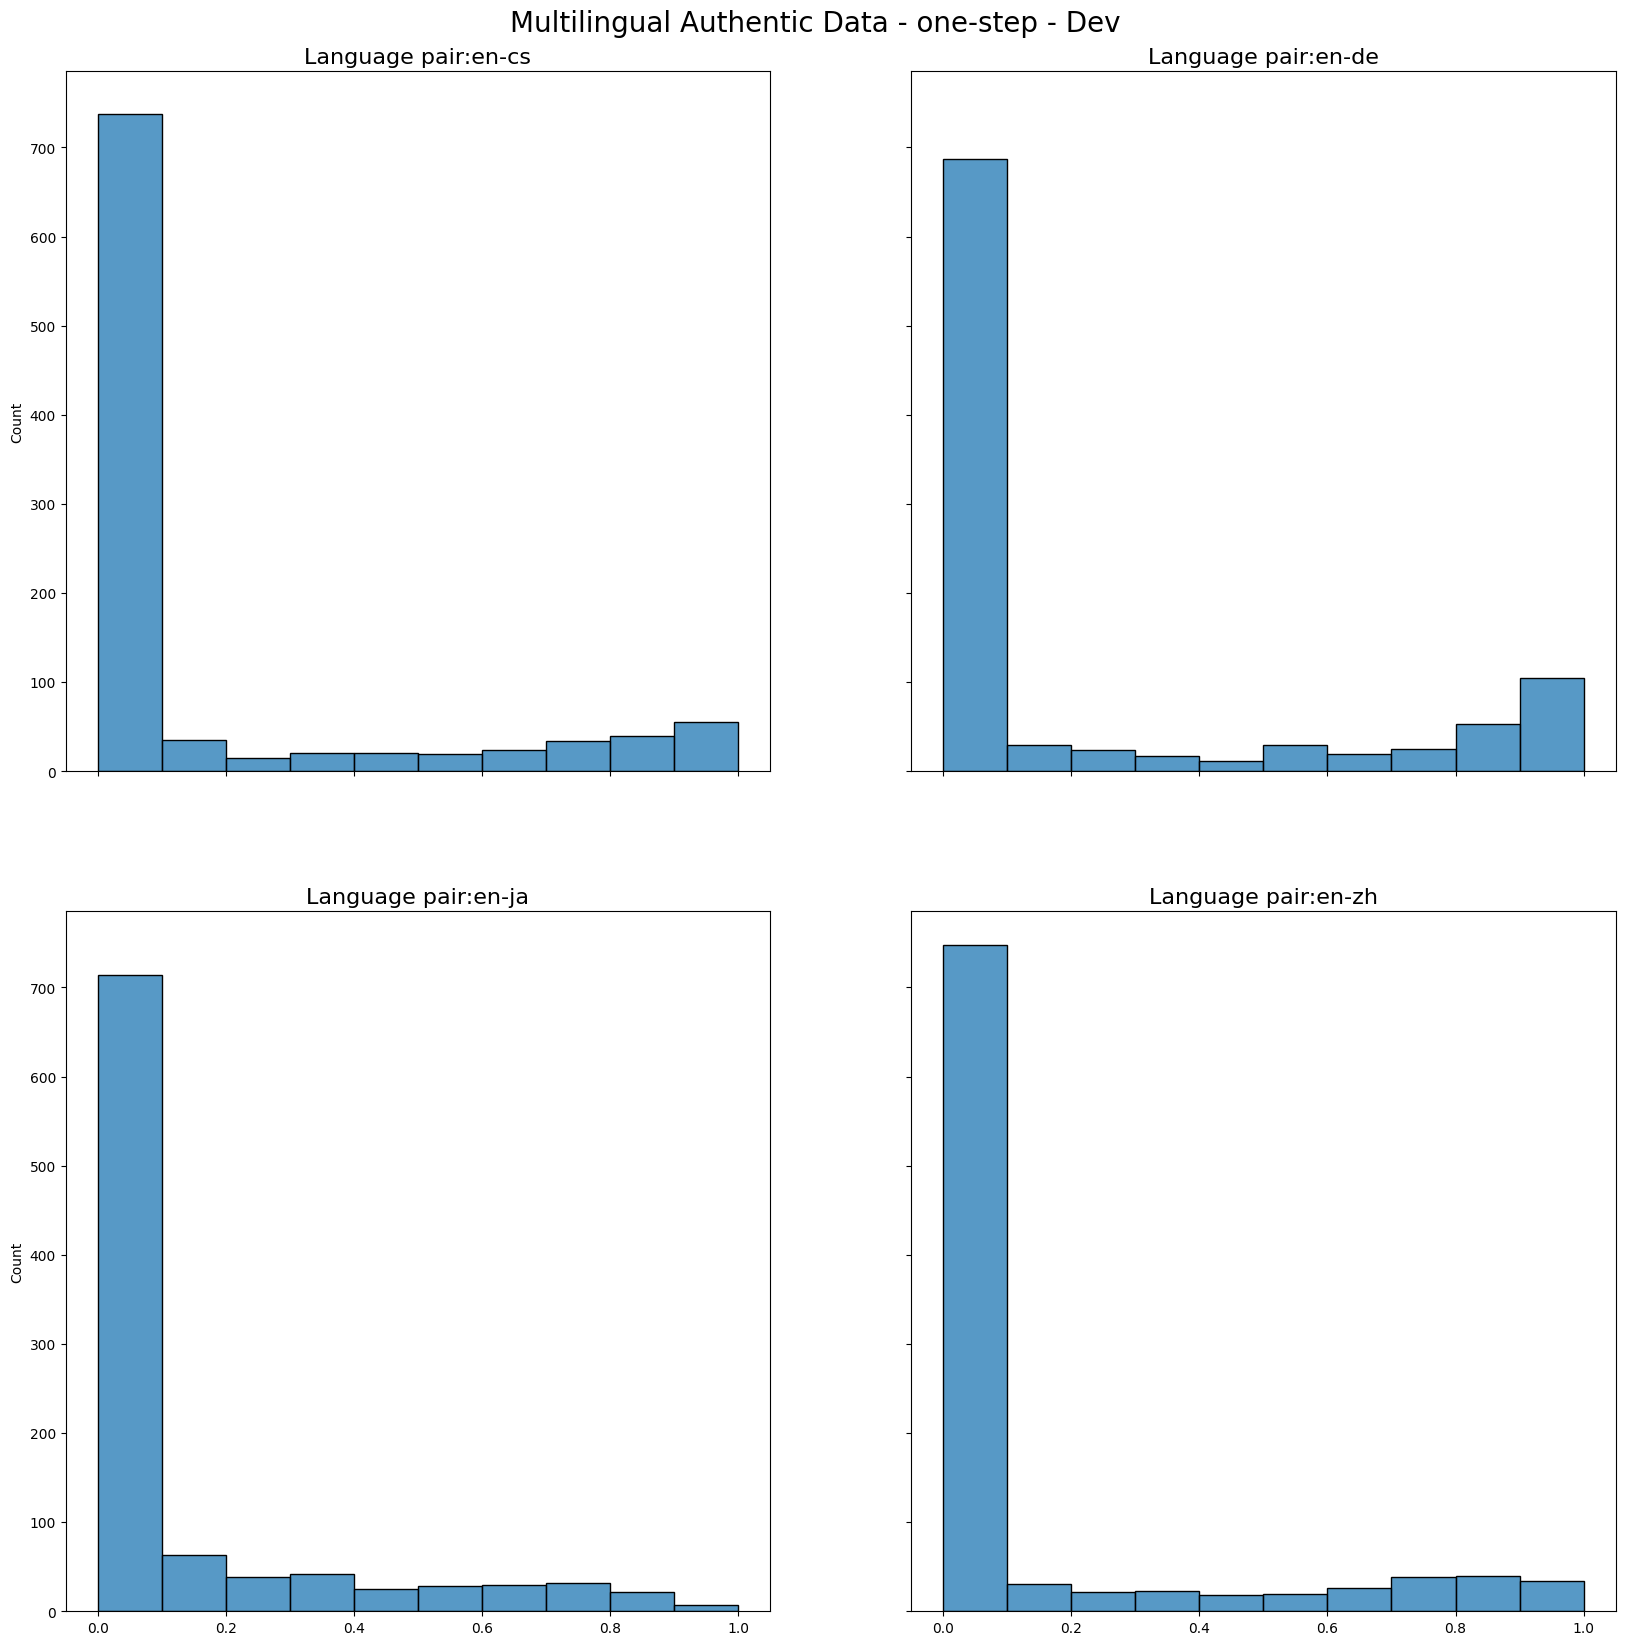

In [44]:
# Plot histogram showing distribution of raw scores
fig = create_histogram_plot(CHART_NAME + ' - Dev', titles, preds)

In [45]:
# Get values for calibration plot
x_vals = []
y_vals = []
for ind, _ in enumerate(preds):
    y, x = calibration_curve(targets[ind], preds[ind], n_bins=10)
    x_vals.append(x)
    y_vals.append(y)

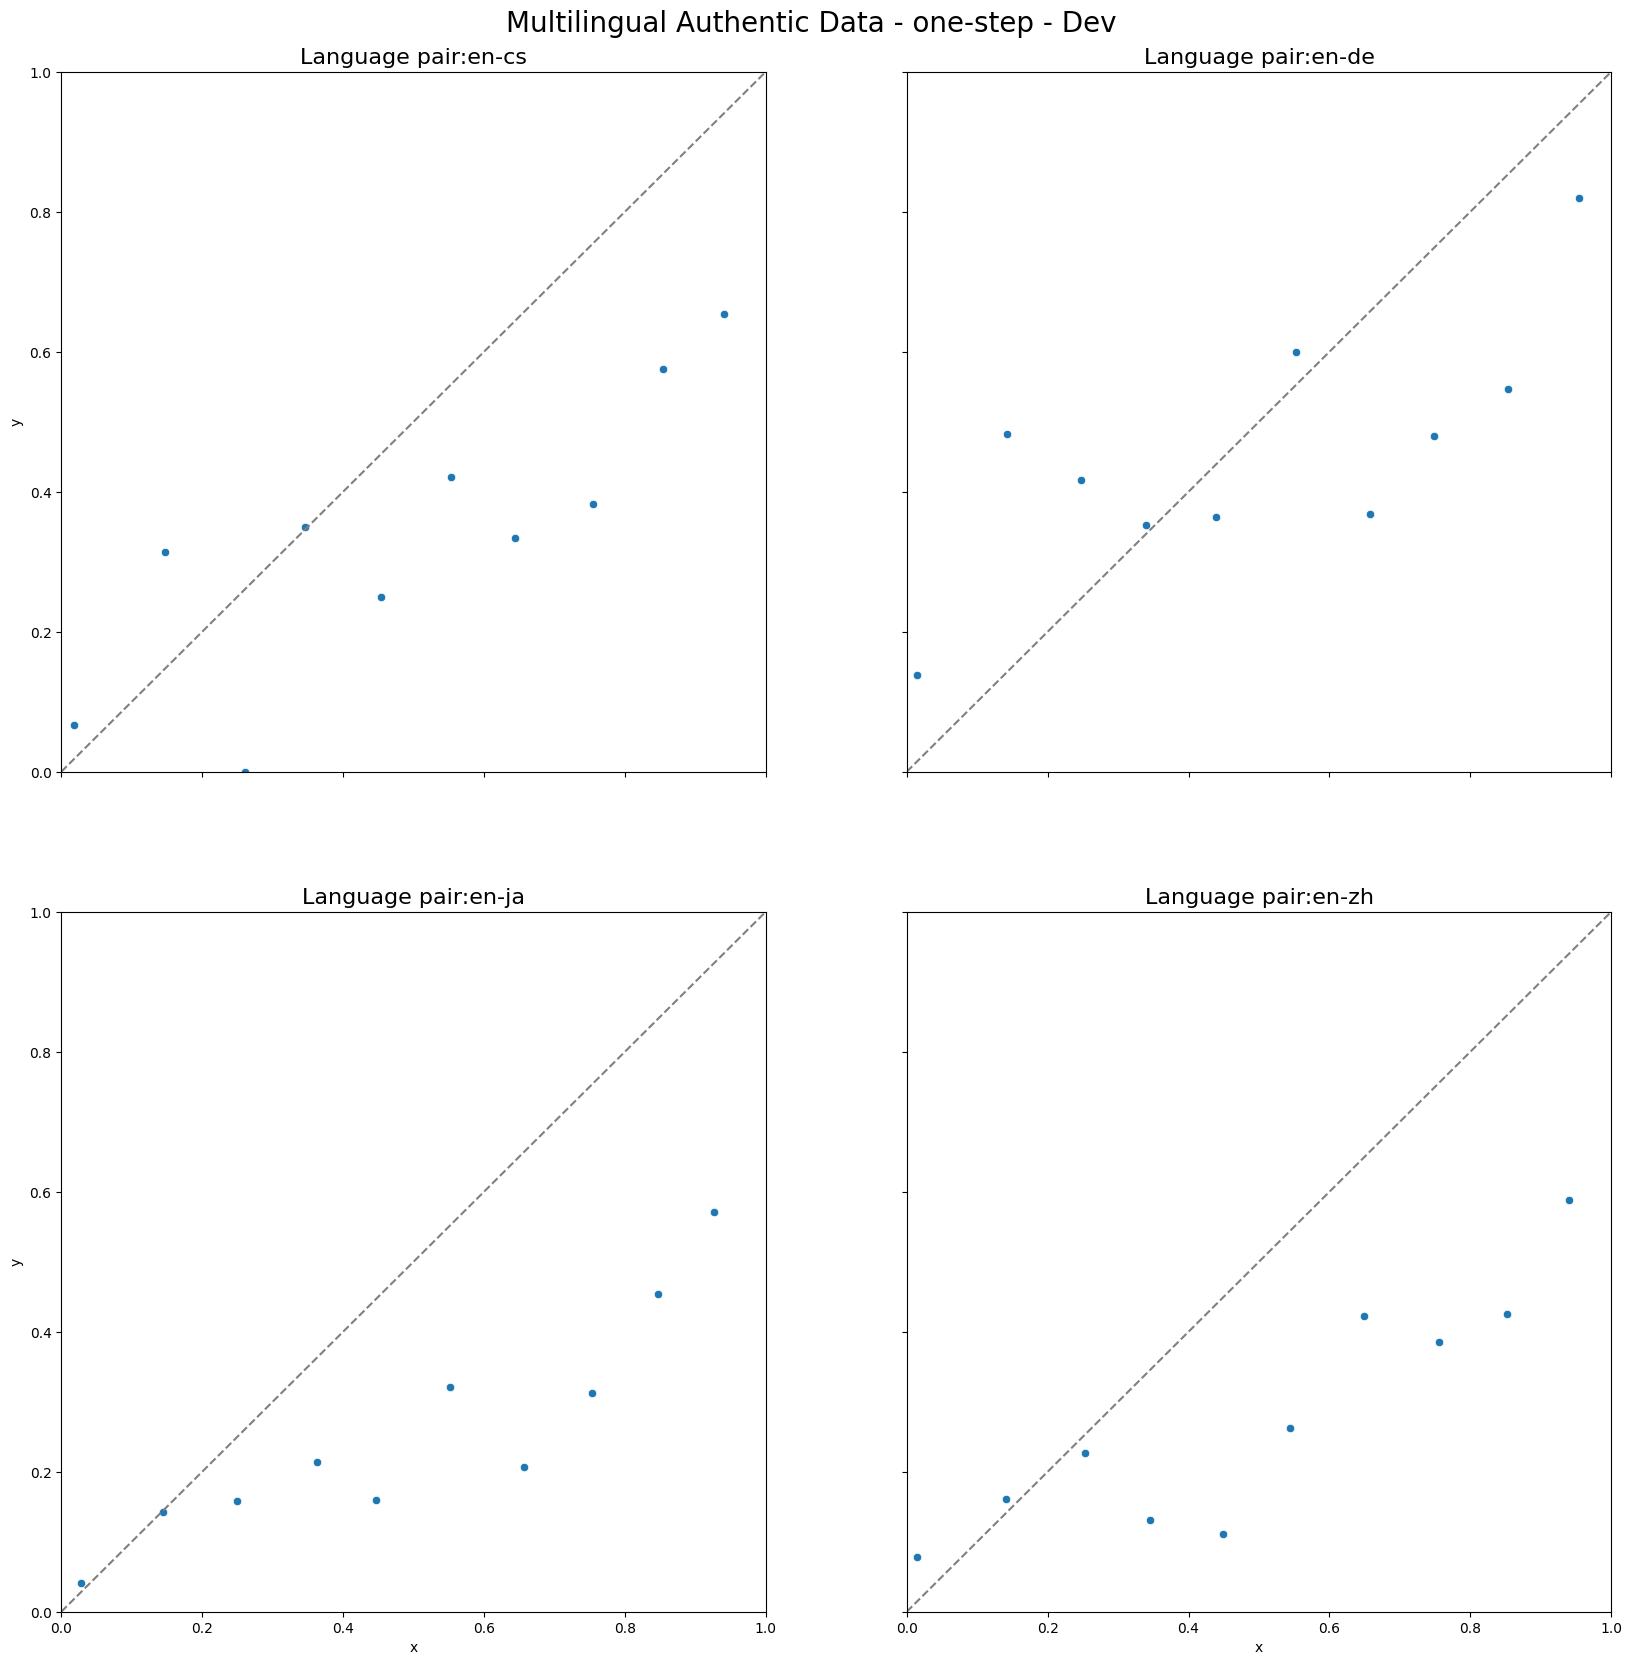

In [46]:
fig = create_calib_plot(CHART_NAME + ' - Dev', titles, x_vals, y_vals)

In [47]:
# Get lists of test data to create plot
test_preds = []
test_targets = []
test_indices = []
titles = []
for lp in LI_LANGUAGE_PAIRS_WMT_21_CED:
    seed = df_eval_test_results[df_eval_test_results['language_pair']==lp].iloc[0]['seed']
    mcc = df_eval_test_results[df_eval_test_results['language_pair']==lp].iloc[0]['MCC']
    precision = df_eval_test_results[df_eval_test_results['language_pair']==lp].iloc[0]['precision']
    recall = df_eval_test_results[df_eval_test_results['language_pair']==lp].iloc[0]['recall']
    titles.append('Language pair:' + lp)
    threshold = df_eval_test_results[df_eval_test_results['language_pair']==lp].iloc[0]['threshold']
    file_prefix = lp + '_' + 'test' + '_' + str(seed)
    if lp == 'en-ja' and enja_separate:
        folder = EXPERIMENT_GROUP_NAME + '_enja'
    else:
        folder = EXPERIMENT_GROUP_NAME
    for file in os.listdir(os.path.join(PREDICTIONS_DIR, 'ced_data', folder)):
        if file.startswith(file_prefix) and file.endswith('.csv'):
            # found predictions
            df_preds = pd.read_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', folder, file))
            scores = df_preds['score'].to_numpy()
            scores = 1 - scores
            test_preds.append(scores)
    test_targets.append(1 - load_ced_test_data(lp)['score'].to_numpy())
    test_indices.append(load_ced_test_data(lp)['idx'])

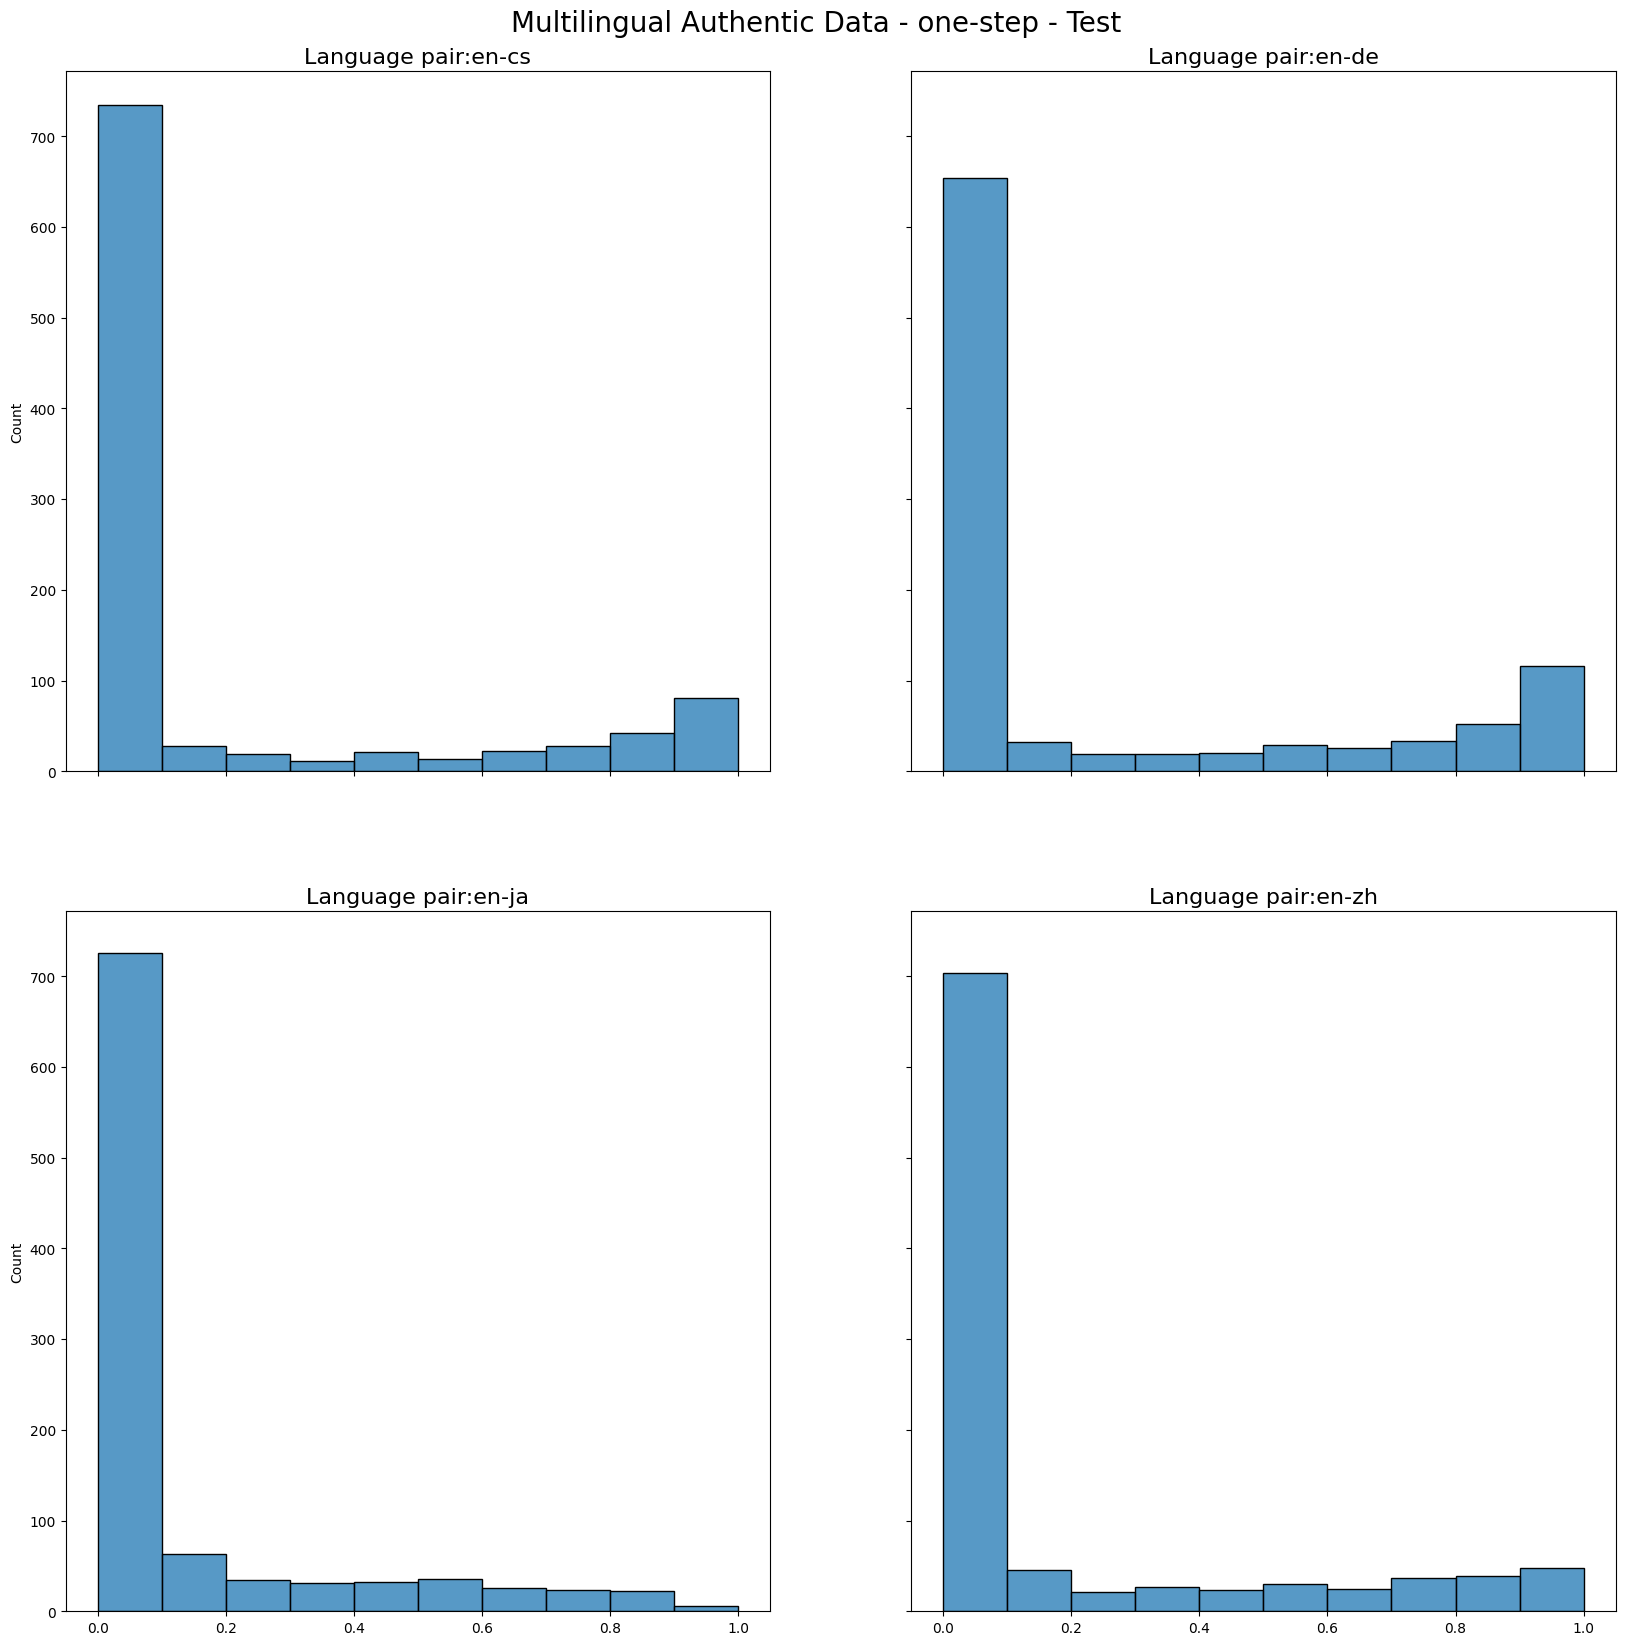

In [48]:
fig = create_histogram_plot(CHART_NAME + ' - Test', titles, test_preds)

In [49]:
x_vals = []
y_vals = []
for ind, _ in enumerate(test_preds):
    y, x = calibration_curve(test_targets[ind], test_preds[ind], n_bins=10)
    x_vals.append(x)
    y_vals.append(y)

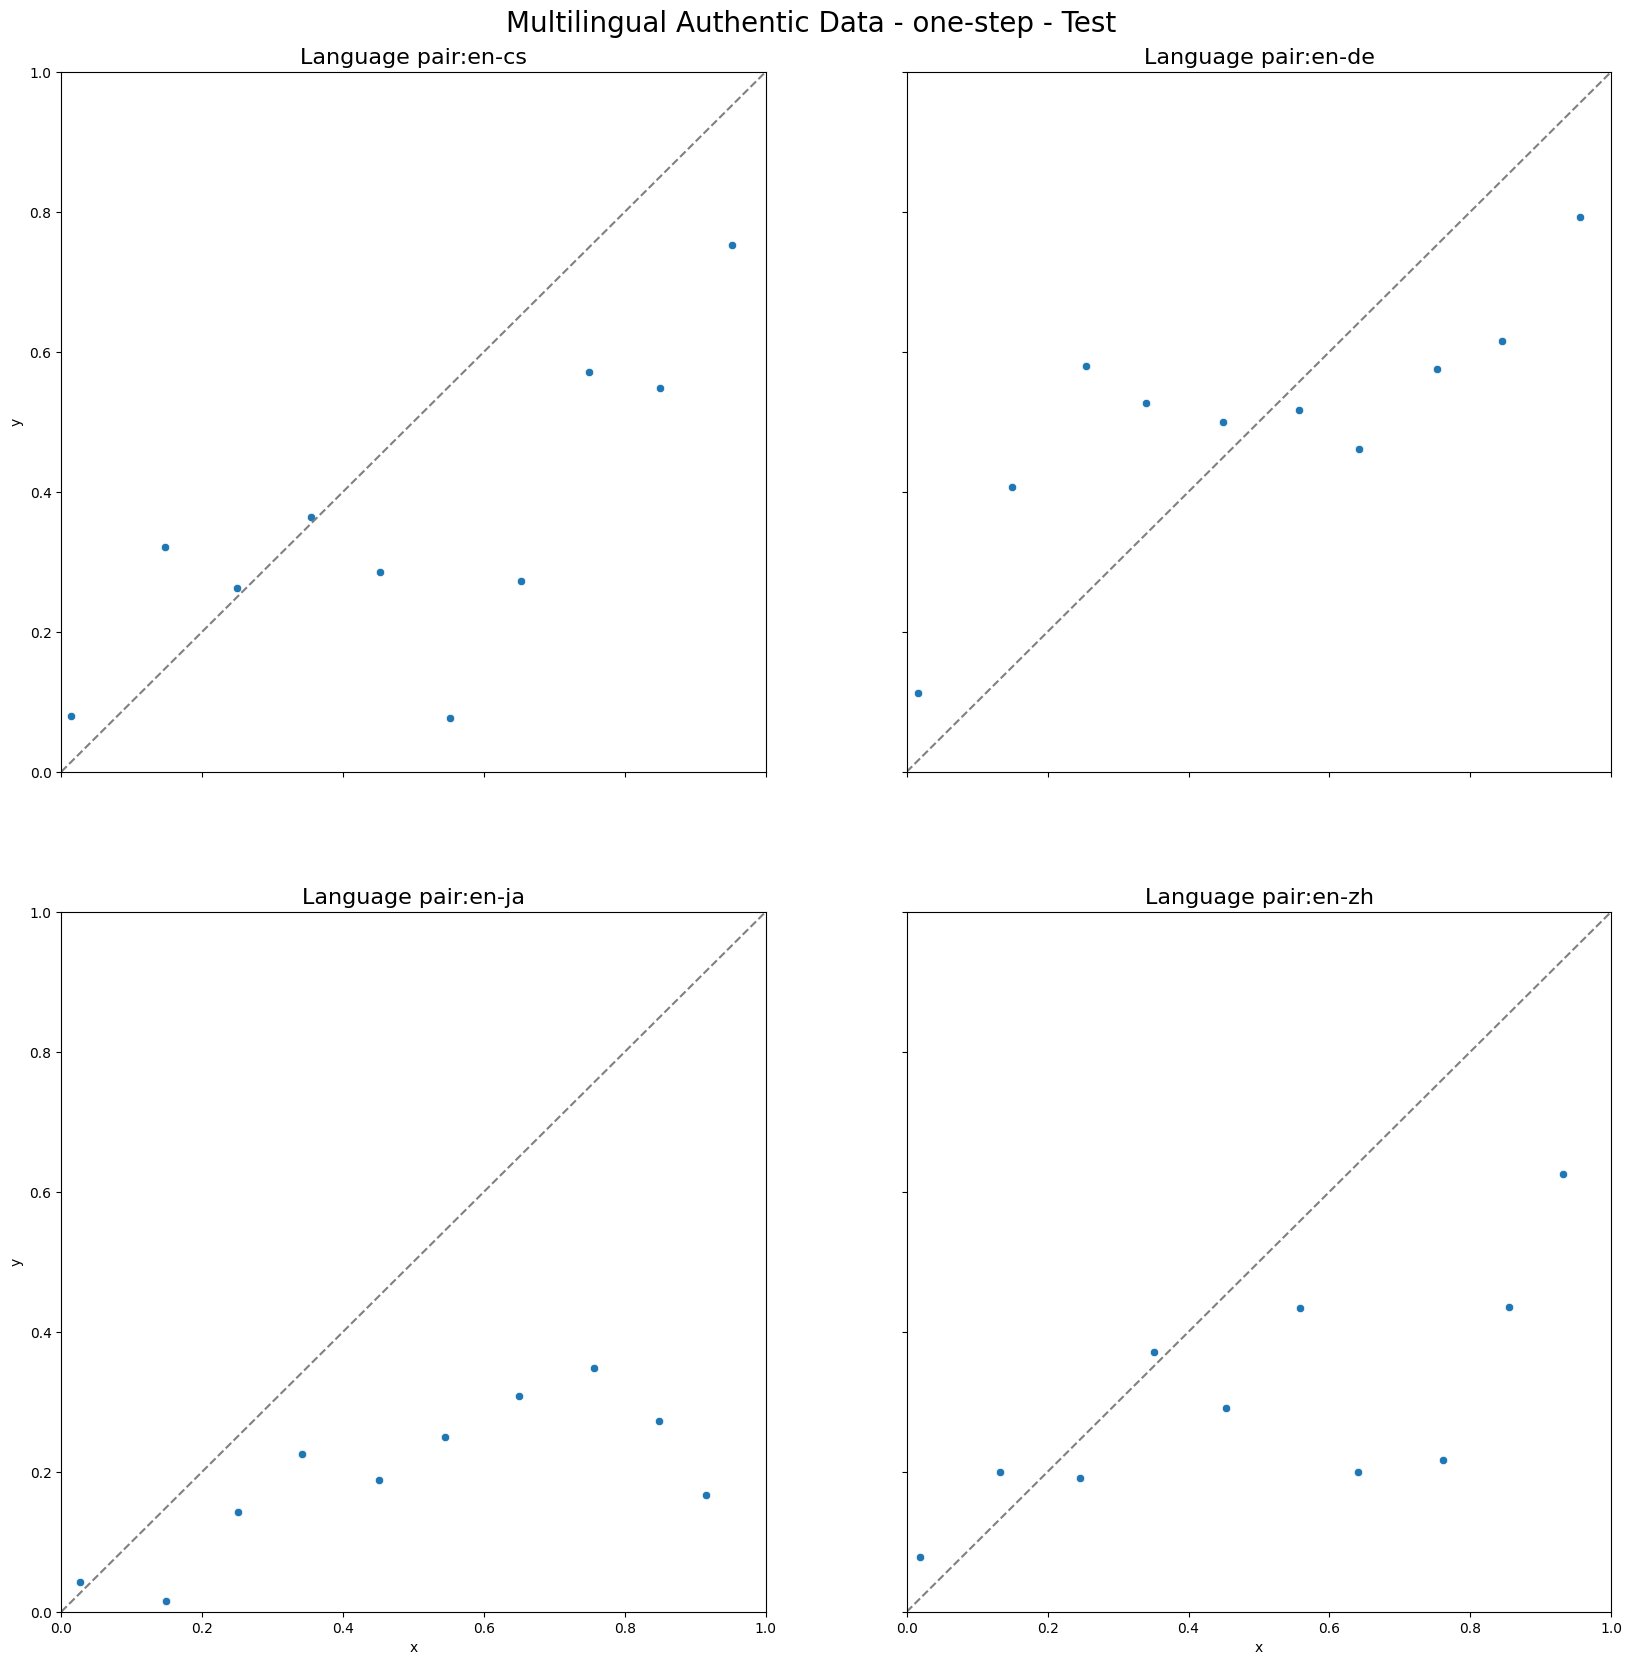

In [50]:
# Calibration plot for test data
fig = create_calib_plot(CHART_NAME + ' - Test', titles, x_vals, y_vals)

In [51]:
# Create a calibration regressor using Isotonic Regression for each language pair using the dev data and apply it 
# to the dev and test data
dev_x_vals = []
dev_y_vals = []
test_x_vals = []
test_y_vals = []
calibrated_test_preds = []
for ind, _ in enumerate(preds):
    iso_reg = IsotonicRegression().fit(preds[ind], targets[ind])
    iso_preds = iso_reg.predict(preds[ind])
    y, x = calibration_curve(targets[ind], iso_preds, n_bins=10)
    dev_x_vals.append(x)
    dev_y_vals.append(y)
    df = pd.DataFrame(1-iso_preds, columns=['score'])
    df.index = indices[ind]
    if not os.path.exists(os.path.join(PREDICTIONS_DIR, 'ced_data', EXPERIMENT_GROUP_NAME + '_calibrated')):
        os.mkdir(os.path.join(PREDICTIONS_DIR, 'ced_data', EXPERIMENT_GROUP_NAME + '_calibrated'))
    df.to_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', EXPERIMENT_GROUP_NAME + '_calibrated', LI_LANGUAGE_PAIRS_WMT_21_CED[ind] + '_dev_0.csv'))

    iso_test_preds = iso_reg.predict(test_preds[ind])
    calibrated_test_preds.append(iso_test_preds)
    y, x = calibration_curve(test_targets[ind], iso_test_preds, n_bins=10)
    test_x_vals.append(x)
    test_y_vals.append(y)
    df = pd.DataFrame(1-iso_test_preds, columns=['score'])
    df.index = test_indices[ind]
    df.to_csv(os.path.join(PREDICTIONS_DIR, 'ced_data', EXPERIMENT_GROUP_NAME + '_calibrated', LI_LANGUAGE_PAIRS_WMT_21_CED[ind] + '_test_0.csv'))
    

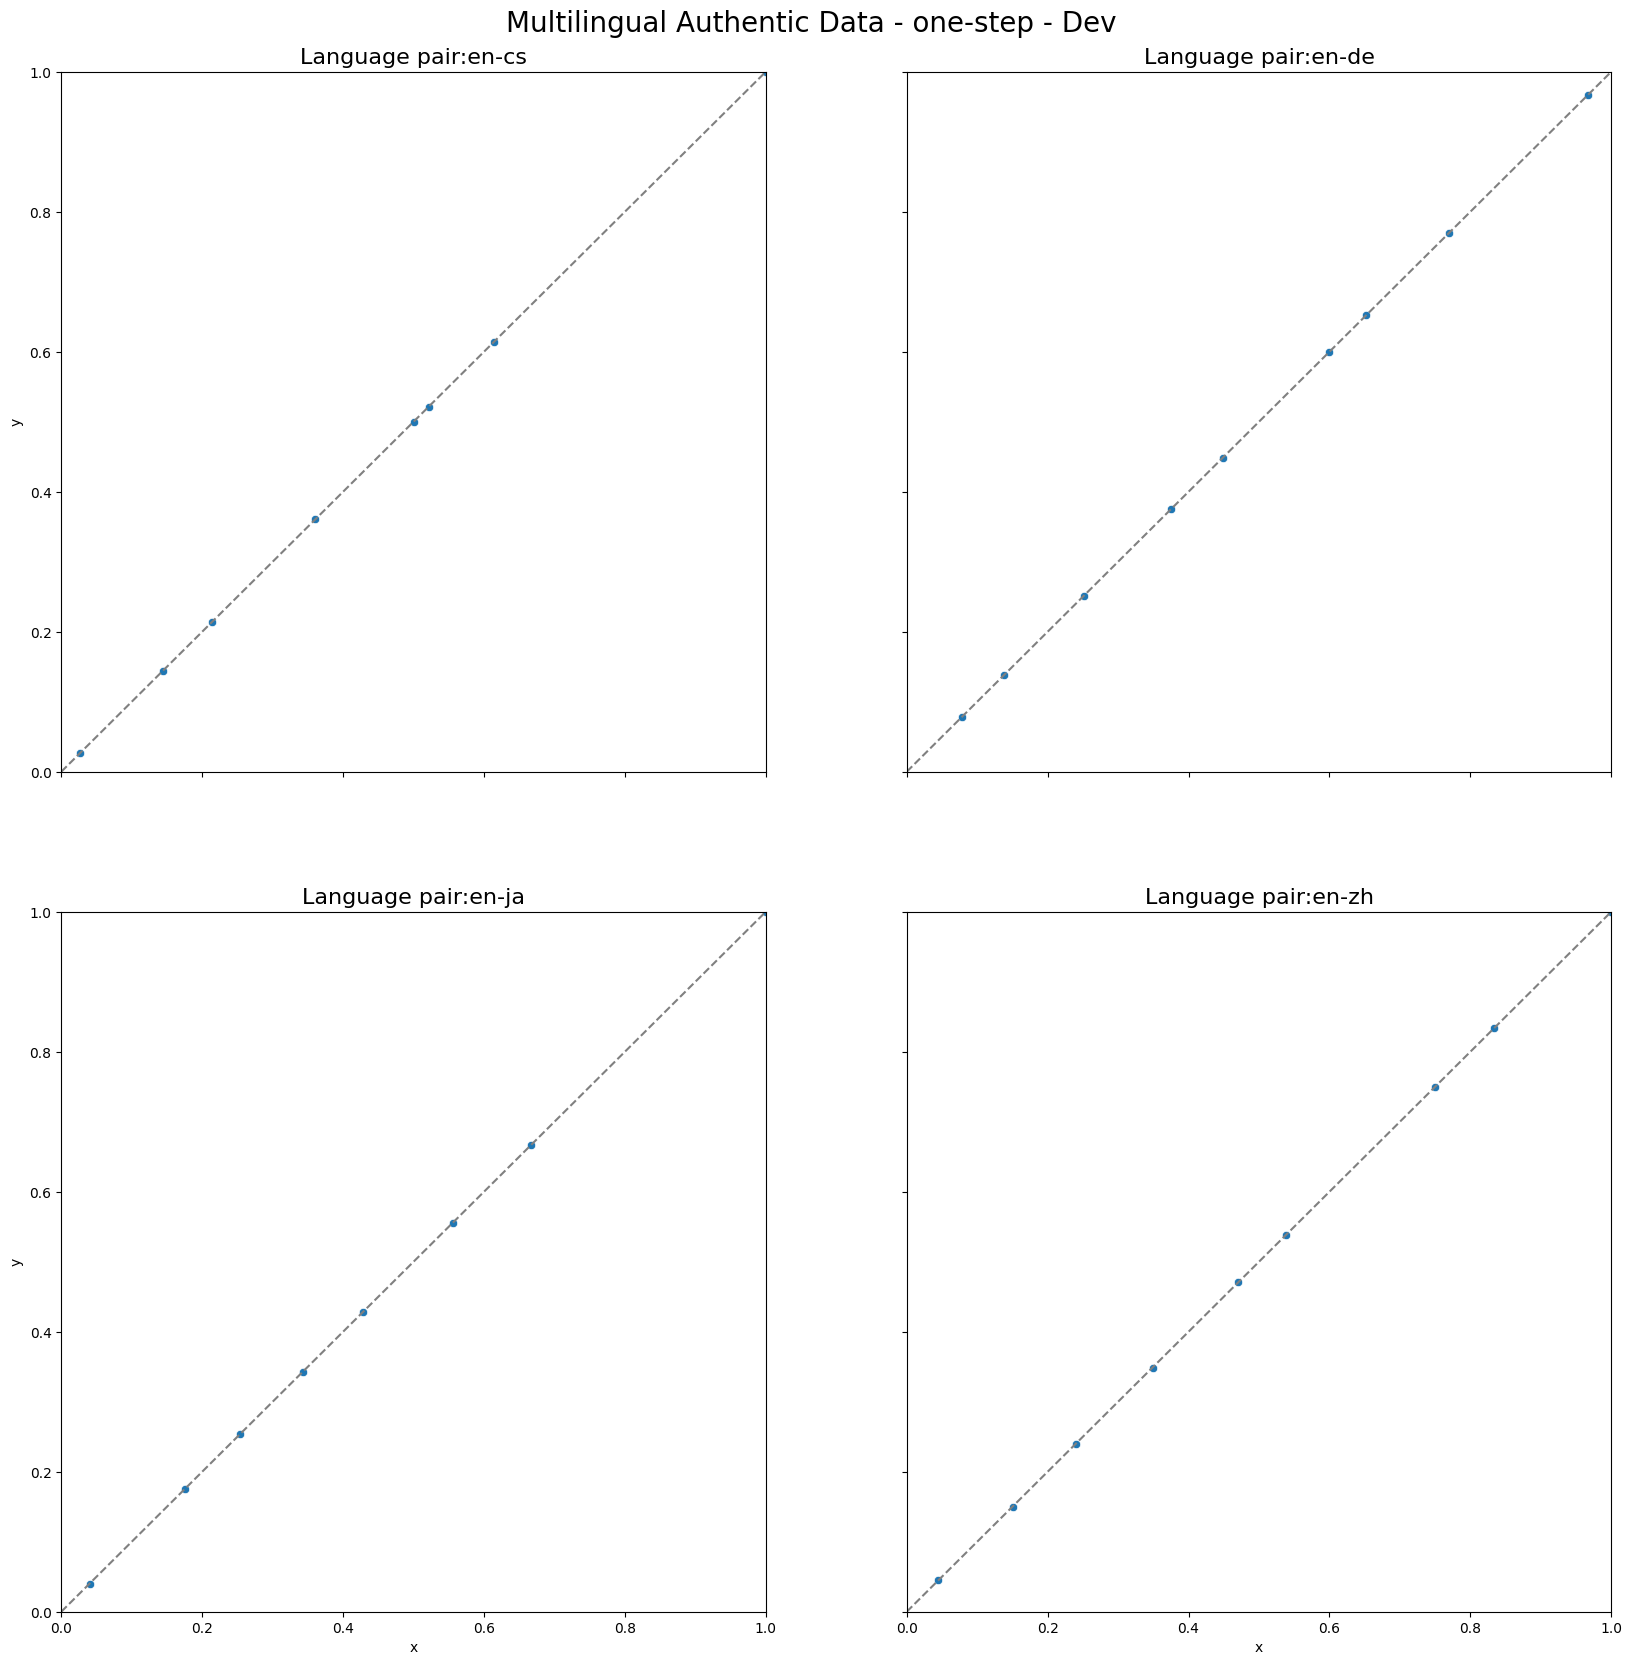

In [52]:
# Plot to show calibration on Dev set after applying Isotonic Regression
fig = create_calib_plot(CHART_NAME + ' - Dev', titles, dev_x_vals, dev_y_vals)

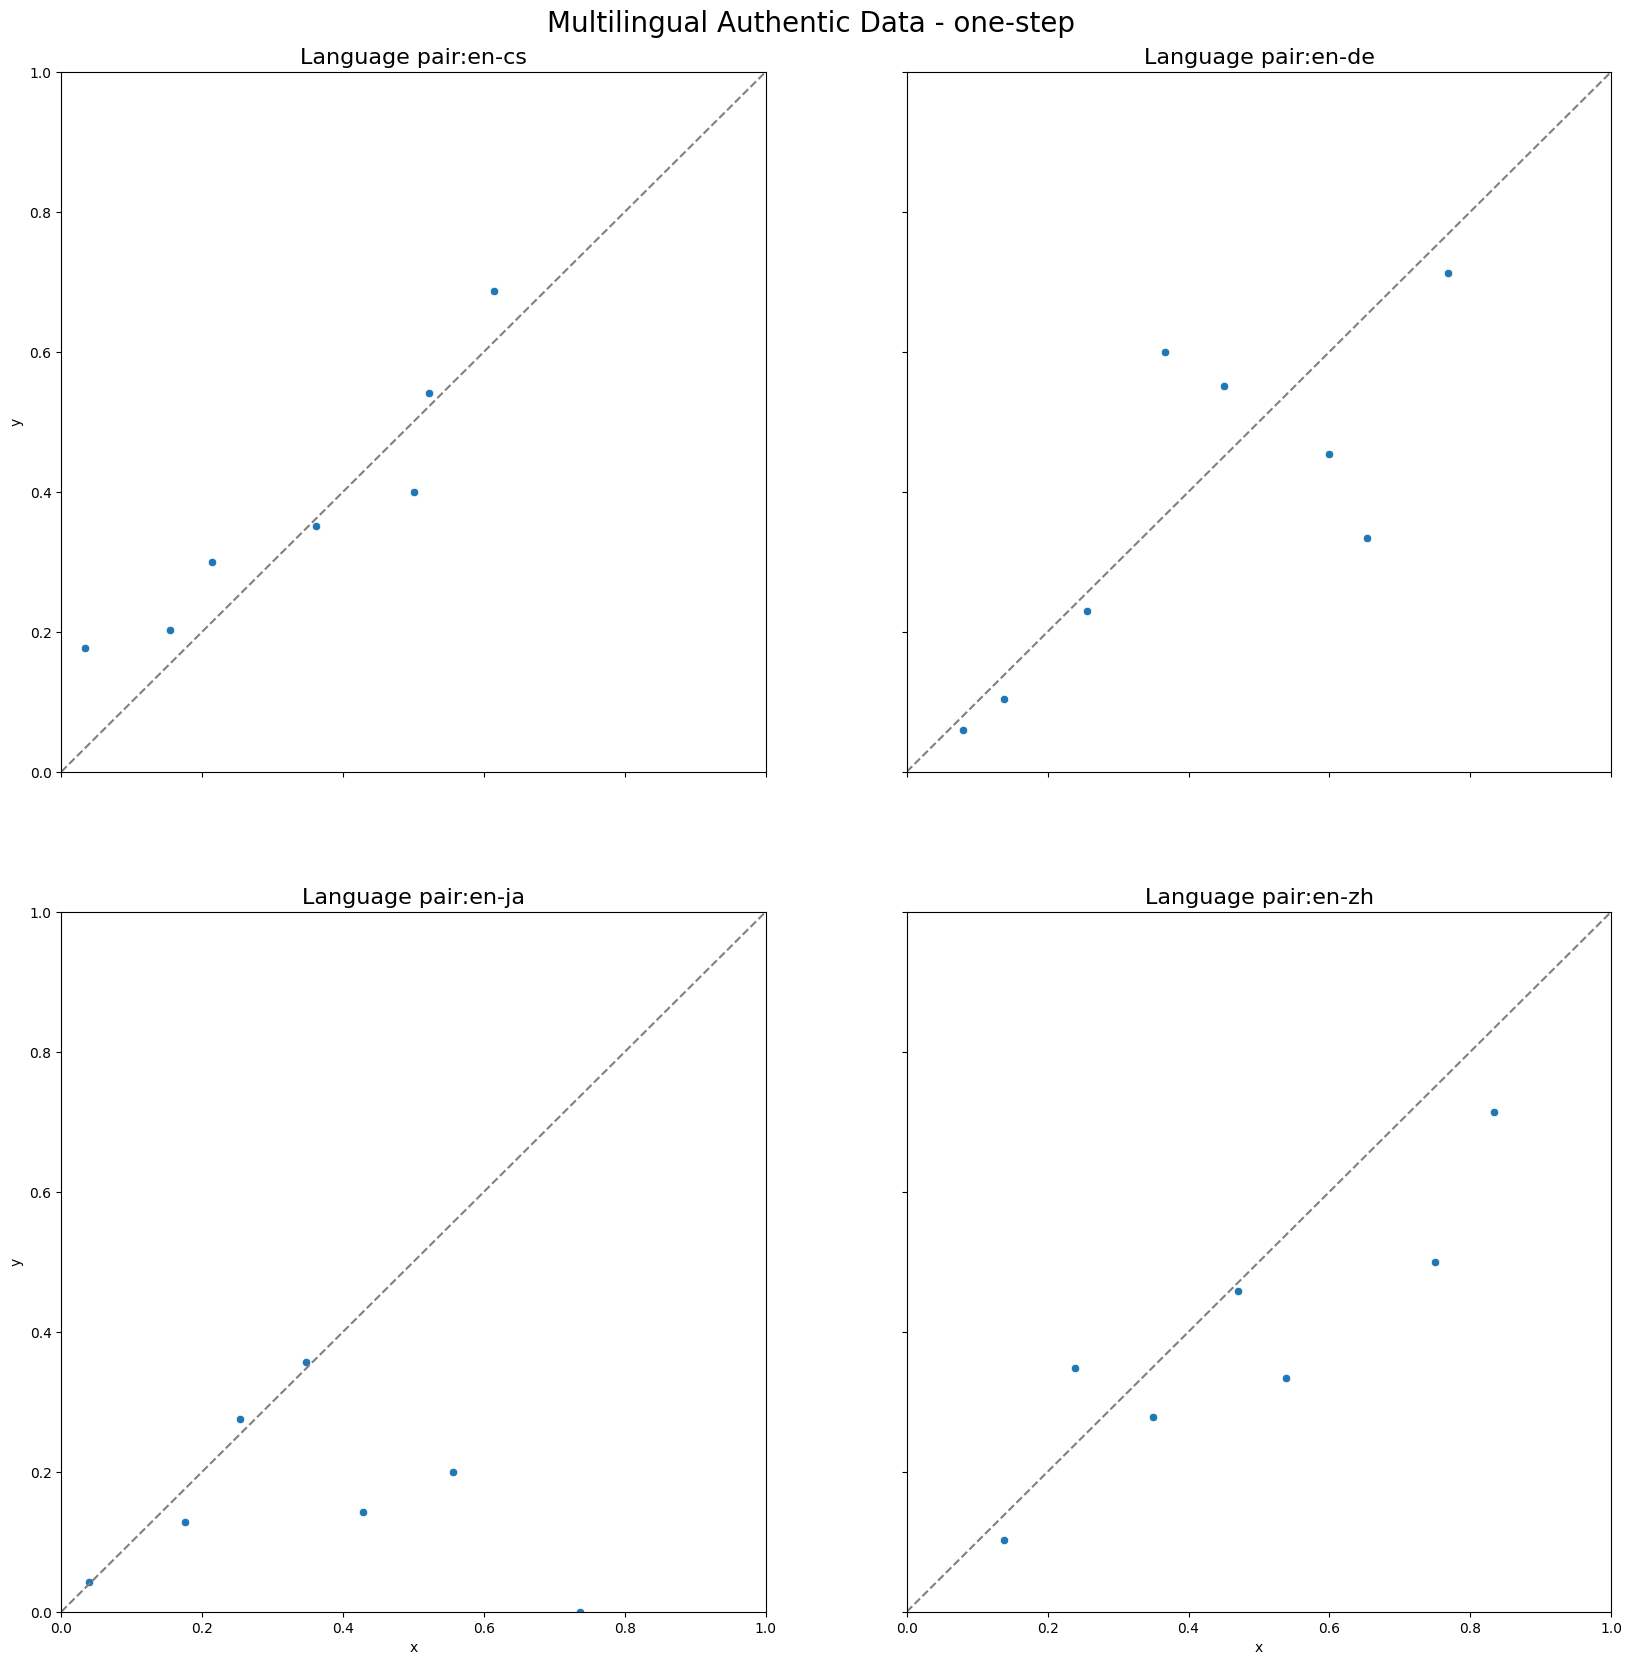

In [53]:
# Plot to show calibration on Test set after applying Isotonic Regression
fig = create_calib_plot(CHART_NAME, titles, test_x_vals, test_y_vals)